# Introduction

This notebook describes the gear ratio selection for a small rally race car powered by a Hayabusa engine.

## Gear Ratio

For a given gearbox, vehicle speed $V_x$ is given by the equation:

$
\begin{align}
V_x = \frac{RPM \frac{2\pi}{60} R_r}{i_{f} i_{n}} [m/s]
\end{align}
$

where,

- $RPM$ is the engine speed in [rpm];
- $\frac{2\pi}{60}$ converts [rpm] to [rps];
- $R_r$ is the tire effective tire rolling radius in [m];
- $i_{f}$ is the final gear ratio (from the diff) [-];
- $i_n$ is the n_gear ratio [-].

For motorcycle-engined vehicle, there is a primary ratio between the cranckshaft and the gearbox, and a drop gear ratio from the pinion / sprocket or gears (in case of a drop gear / diff unit [[1](https://shop.quaife.co.uk/quaife-universal-gear-driven-transfer-unit)] [[2](http://eliteracingtransmissions.com/product/mx250-gearbox-plated-lsd/)]). In this
case, vehicle speed is given by:

$
\begin{align}
V_x = \frac{RPM \frac{2\pi}{60} R_r}{i_{f} i_{n}  i_{p} i_{d}} [m/s]
\end{align}
$

where, 

- $i_{p}$ is the primary gear ratio [-];
- $i_{d}$ is the drop gear ratio [-].

# Load Data Input

Input data is a pre-formatted excel file which takes the various sets of input arguments, named *setups*. Each row is a different set of input (i.e. different *setup*).

Let's take a look on how the input data is structured:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_input = pd.read_excel('00_gearbox_input_example.xlsx')
data_input

,setup,comments,engine_max_speed,tire_rolling_radius,i_primary,i_drop,i_final,i_1,i_2,i_3,i_4,i_5,i_6
0,0,example 1,10500,0.393,1.6,3.025,1.83,2.615,1.938,1.526,1.286,1.136,1.043
1,1,example 2,10500,0.363,NaN,NaN,3.50,2.615,1.938,1.526,1.286,1.136,NaN


Note: 

It is not required to fill i_primary $i_{p}$ and i_drop $i_{d}$. If the value is NaN, gearbox() function will assign a value of 1. In the same way, not all gear ratios have to be filled.

# Function *gearbox()*

In [4]:
def gearbox(data_input, *data_freq):
    
    """
    The function **gearbox(data_input, data_freq)** returns the gear ratio to a DataFrame.
    
    Keyworks arguments:
    data_input -- input parameters from a from a pre-formatted excel file 
    data_freq -- frequency of the output DataFrame [Hz]
    
    Output:
    - gear [-]
    - gear ratio [-]
    - engine speed in [rpm]
    - vehicle speed in [m/s]
    - vehicle speed in [km/h]
    """
    
    data_input = pd.read_excel(data_input)
    rpm2rps = 2*np.pi/60
    
    if data_freq == ():
        data_freq = 0.1
    else:
        data_freq = data_freq[0]
        
    rpm_step = 1 / data_freq
    
    vehicle_speed = []
    engine_speed = []
    gear_number = []
    gear_ratio = []
    setup_list = []

    # Loops through each setup input of the data_input.xlsx
    for setup in range(0, len(data_input)):

        data = data_input[data_input['setup'] == setup]
        i_final = float(data['i_final'])
        tire_rolling_radius = float(data['tire_rolling_radius'])

        # Checks if i_drop and i_primary are NaN
        for ratio in ['i_drop', 'i_primary']:
            if np.isnan(data[ratio].iloc[0]): 
                i_drop = 1
                i_primary = 1 
            else:
                i_drop = float(data['i_drop'])
                i_primary = float(data['i_primary'])
        
        # This variable is defined to ensure the condition to run loops from i_2 to i_n gears do not
        # get the max(vehicle_speed) value from the entire data, only from data imediatelly from the
        # previously gear.
        search_backwards = int(data['engine_max_speed'] / (2*rpm_step))
        
        # Gets the index of the first gear
        i_1_index = data.columns.get_loc('i_1')

        # Creates a list containing the number of gears. Ex: 6 gears would return [1, 2, 3, 4, 5, 6].
        gear_num = list(range(1, len(data.columns) - (i_1_index - 1)))
        
        # Creats a list containing the gear ratios corresponding to each gear:
        gear_ratio = list(data.iloc[0, i] for i in range(i_1_index, len(data.columns)))

        # Loops through each gear:
        for i in range(0, len(gear_num)):
            
            # Loops thrugh RPM range:
            for rpm in np.arange(0, int(data['engine_max_speed'] + 1), rpm_step):
                
                vehicle_speed_loop = (rpm*rpm2rps*tire_rolling_radius 
                                      / (i_drop*i_final*i_primary*gear_ratio[i]))

                # i_1 stores vehicle_speed from 0 to engine_max_speed:
                if gear_num[i] == 1:
                    vehicle_speed.append(vehicle_speed_loop)
                    engine_speed.append(rpm)
                    gear_ratio.append(gear_ratio[i])
                    gear_number.append(gear_num[i])
                    setup_list.append(int(setup))

                # i_2 to i_n stores vehicle_speed only from the previusly max_speed:    
                else:                 
                    if vehicle_speed_loop > max(vehicle_speed[-search_backwards:]):
                        vehicle_speed.append(vehicle_speed_loop)
                        engine_speed.append(rpm)
                        gear_ratio.append(gear_ratio[i])
                        gear_number.append(gear_num[i])
                        setup_list.append(int(setup))


        gearbox_data = pd.DataFrame({'gear':gear_number,
                                'rpm':engine_speed,
                                'speed_[m/s]':vehicle_speed,
                                'setup':setup_list}) 

        gearbox_data['speed_[km/h]'] = gearbox_data['speed_[m/s]']*3.6

    return gearbox_data

Let's call the function to see how de output is structured:

In [5]:
gearbox_data = gearbox('00_gearbox_input_example.xlsx')   
gearbox_data.head()

,gear,rpm,speed_[m/s],setup,speed_[km/h]
0,1,0.0,0.000000,0,0.000000
1,1,10.0,0.017769,0,0.063967
2,1,20.0,0.035537,0,0.127934
3,1,30.0,0.053306,0,0.191901
4,1,40.0,0.071074,0,0.255868


Different setups are acessed filtering the data:

In [6]:
gearbox_data[gearbox_data.setup == 1].head()

,gear,rpm,speed_[m/s],setup,speed_[km/h]
1922,1,0.0,0.000000,1,0.000000
1923,1,10.0,0.041533,1,0.149520
1924,1,20.0,0.083066,1,0.299039
1925,1,30.0,0.124600,1,0.448559
1926,1,40.0,0.166133,1,0.598078


# Gear Ratio Comparison

In this section we are going to compare different gear ratios using both an Elite MX-250 diff unit and a single chain drive.

## Elite MX-250 diff unit

This Elite MX-250 drop ratio / diff unit is being used in a offroad project. It currently has two gear sets, named *long* and *short* gear ratios. It also has two options of tire size, 30" and 32". Let's load input data and plot some RPM vs. Speed charts.

In [7]:
pd.read_excel('00_gearbox_input_mx_250.xlsx')

,setup,comments,engine_max_speed,tire_rolling_radius,i_primary,i_drop,i_final,i_1,i_2,i_3,i_4,i_5,i_6
0,0,"long 32""",10500,0.398,1.596,1.352941,3.888889,2.615,1.938,1.526,1.286,1.136,1.043
1,1,"long 30""",10500,0.373,1.596,1.352941,3.888889,2.615,1.938,1.526,1.286,1.136,1.043
2,2,"short 32""",10500,0.398,1.596,1.785714,3.888889,2.615,1.938,1.526,1.286,1.136,1.043
3,3,"short 30""",10500,0.373,1.596,1.785714,3.888889,2.615,1.938,1.526,1.286,1.136,1.043


In [8]:
gearbox_data = gearbox('00_gearbox_input_mx_250.xlsx')  
gearbox_data.columns

Index(['gear', 'rpm', 'speed_[m/s]', 'setup', 'speed_[km/h]'], dtype='object')

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_gear_ratio(setup, title, x_lim, legend=['']):

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    i = 0
    
    for setup in setup:
        ax.plot('speed_[km/h]', 'rpm', data=gearbox_data[gearbox_data.setup == setup], label=legend[i])
    
        ax.annotate(str(round(max(gearbox_data[gearbox_data.setup == setup]['speed_[km/h]']),1)),
                    (max(gearbox_data[gearbox_data.setup == setup]['speed_[km/h]'])*(1-0.02*i), 10600))  
        i =+ 1

    ax.set_xlabel('vehicle speed [km/h]')
    ax.set_ylabel('engine speed [rpm]') 
    ax.grid(linestyle=':', alpha=0.5)
    ax.set_xlim(x_lim)
    ax.set_ylim(4000, 11000)
    ax.set_title(title)
    if legend== ['']:
        pass
    else:
        ax.legend(loc='lower right')

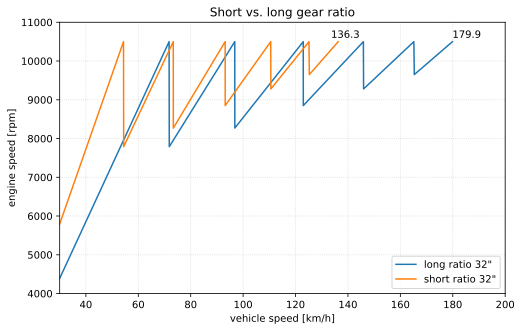

In [10]:
setup = [0,2]
legend = ['long ratio 32"', 'short ratio 32"']
title = 'Short vs. long gear ratio'
x_lim = (30, 200)
plot_gear_ratio(setup, title, x_lim, legend)

Now let's compare the tire size to see the impact on the gear ratio:

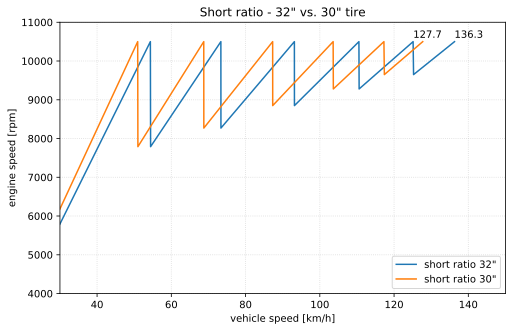

In [11]:
setup = [2,3]
legend = ['short ratio 32"', 'short ratio 30"']
title = 'Short ratio - 32" vs. 30" tire'
x_lim = (30, 150)
plot_gear_ratio(setup, title, x_lim, legend)

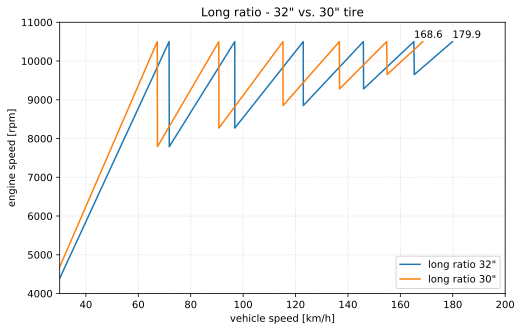

In [12]:
setup = [0,1]
legend = ['long ratio 32"', 'long ratio 30"']
title = 'Long ratio - 32" vs. 30" tire'
x_lim = (30, 200)
plot_gear_ratio(setup, title, x_lim, legend)

## Chain Drive Setup

This project could also have low cost version using chain drive instead of the Elite MX-250 diff unit.
The gear ratios should be the same as the diff unit. In this case we have:

- $i_f = 35/9$ is the final gear ratio of the diff; 
- $i_{d\_long} = 23/17$ is the long drop ratio; 
- $i_{d\_short} = 25/14$ is the short drop ratio.

The chain ratio $i_{chain}$ is given by:

$
\begin{align}
i_{chain} = \frac{t_{driven}}{t_{driver}}
\end{align}
$

where, 

- $t_{driver}$ is the number of teeth of the engine sprocket; 
- $t_{driven}$ is the number of teeth of the driven sprocket;

The original sprocket of the Hayabusa engine has 18 teeths $t_{driver}$.
So, to keep the same gear ratio we should have:

$
\begin{align}
i_{chain} = i_{d\_long}i_f \longrightarrow t_{driven} = 18 \frac{23}{17} \frac{35}{9} = 95  \mbox{ teeth}
\end{align}
$

Which is unfeasible, the driven sprocket is way too big. We could get better results using the smaller driver sprocket commercial available. According to the owner manual of the GSX1300R 2008, the original chain is a 530 pitch. The smallest available has 14 teeths and the biggest driven sprocket has 66 teeth.

$
\begin{align}
i_{chain} = \frac{66}{14}
\end{align}
$

Let's see how the gear chart looks like:

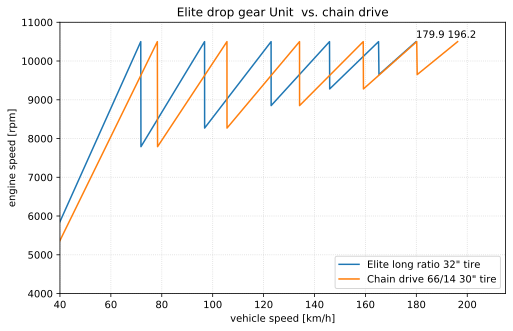

In [13]:
gearbox_data = gearbox('00_gearbox_input_chain_drive.xlsx') 

setup = [0,2]
legend = ['Elite long ratio 32" tire', 'Chain drive 66/14 30" tire']
title = 'Elite drop gear Unit  vs. chain drive'
x_lim = (40, 215)
plot_gear_ratio(setup, title, x_lim, legend)

Although this chain drive gear ratio is longer than the MX-250 *long ratio*, at least is feasible to achieve. Better results could be achieved using custom pinion and sprockets intead of the aftermarket ones.